# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Reference : https://365datascience.com/pca-k-means/

In [107]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
# Loading our preprocessed data from part 0
# scaled_azdias=pd.read_pickle("scaled_azdias.pkl")
# scaled_customers=pd.read_pickle("scaled_customers.pkl")

In [4]:
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
ambiguity_10=['WOHNDAUER_2008', 'KKK', 'W_KEIT_KIND_HH', 'ALTERSKATEGORIE_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'KBA05_GBZ', 'TITEL_KZ', 'REGIOTYP', 'KBA05_BAUMAX', 'HH_EINKOMMEN_SCORE', 'GEBAEUDETYP', 'ANREDE_KZ']
ambiguity_90=['KBA05_HERST1', 'KBA05_ALTER4', 'KBA05_SEG3', 'SEMIO_KRIT', 'KBA05_KRSKLEIN', 'KBA05_MOD4', 'KBA05_HERST5', 'KBA05_SEG4', 'KBA05_ZUL3', 'KBA05_ZUL4', 'SEMIO_PFLICHT', 'KBA05_KRSZUL', 'KBA05_FRAU', 'KBA05_KRSAQUOT', 'KBA05_MAXBJ', 'KBA05_ZUL1', 'KBA05_MOTOR', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MOD3', 'SEMIO_SOZ', 'KBA05_MODTEMP', 'KBA05_SEG1', 'KBA05_SEG9', 'SEMIO_FAM', 'SEMIO_KAEM', 'KBA05_ALTER1', 'KBA05_DIESEL', 'KBA05_HERST4', 'KBA05_MAXSEG', 'KBA05_MOTRAD', 'RELAT_AB', 'SEMIO_ERL', 'KBA05_MOD2', 'KBA05_VORB0', 'KBA05_VORB2', 'KBA05_ALTER3', 'KBA05_KW2', 'KBA05_ANHANG', 'KBA05_MOD8', 'KBA05_SEG6', 'KBA05_SEG5', 'KBA05_KRSOBER', 'KBA05_AUTOQUOT', 'KBA05_ALTER2', 'SEMIO_VERT', 'KBA05_KW1', 'KBA05_SEG8', 'KBA05_VORB1', 'ZABEOTYP', 'KBA05_KRSHERST3', 'KBA05_SEG10', 'KBA05_CCM4', 'SEMIO_LUST', 'KBA05_KRSHERST1', 'KBA05_KRSVAN', 'KBA05_MAXHERST', 'KBA05_SEG7', 'SEMIO_RAT', 'KBA05_CCM3', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_ZUL2', 'KBA05_MAXVORB', 'KBA05_SEG2', 'KBA05_KRSHERST2', 'SEMIO_KULT', 'KBA05_HERSTTEMP', 'SEMIO_REL', 'SEMIO_DOM', 'SEMIO_TRADV', 'KBA05_HERST3', 'KBA05_HERST2', 'KBA05_MOD1', 'SEMIO_MAT']
from sklearn.preprocessing import StandardScaler
def preprocess(df,name=None):
    print("Shape before",df.shape)
    if name=='customers':
        df=df.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'],axis=1)
    
    if name=='azdias':
        df=df[df.isnull().sum(axis=1)<=20].reset_index(drop=True)
    # finding numeric and categorical columns

    Numeric_columns=df.select_dtypes(include=np.number).columns.tolist()
    categorical_col=set(df.columns).difference(set(Numeric_columns))
    # numeric cols to numeric
    print(categorical_col)
    df[Numeric_columns]=df[Numeric_columns].apply(pd.to_numeric)
    # drop columns to avoid lot of columns
    df=df.drop('D19_LETZTER_KAUF_BRANCHE',axis=1)
    df=df.drop('EINGEFUEGT_AM',axis=1)
    df=df.drop(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1'],axis=1)

    
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']]=df[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']]=df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric)
    #

    df[ambiguity_10]=df[ambiguity_10].replace(0,-1)
    df[ambiguity_90]=df[ambiguity_90].replace(9,-1)
    
    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)
    
    
    df=df.fillna(df.mode().iloc[0])
    print("Number of nan Values",df.isna().sum().sum())
    df=pd.get_dummies(df)
    
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df)
    print("shape after",df.shape)
    df = df.set_index('LNR')
    return df
scaled_azdias=preprocess(azdias,'azdias')
scaled_customers=preprocess(customers,'customers')

/Users/maitreytalware/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape before (891221, 366)
{'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ', 'EINGEFUEGT_AM'}
shape after corr (744305, 252)
Number of nan Values 0
shape after (744305, 297)
Shape before (191652, 369)
{'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ', 'EINGEFUEGT_AM'}
shape after corr (191652, 257)
Number of nan Values 0
shape after (191652, 302)


In [11]:
# scaled_azdias.to_pickle("scaled_azdias.pkl")
# scaled_customers.to_pickle("scaled_customers.pkl")

## Dimensionality Reduction
There are varying reasons for using a dimensionality reduction step such as PCA prior to data segmentation. 
- By reducing the number of features, we’re improving the performance of our algorithm. 
- On top of that, by decreasing the number of features the noise is also reduced.

In [5]:
pca=PCA()
pca.fit(scaled_azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [6]:
pca.explained_variance_ratio_[:6]

array([0.05967456, 0.0413776 , 0.03144057, 0.02616301, 0.02454831,
       0.02210576])

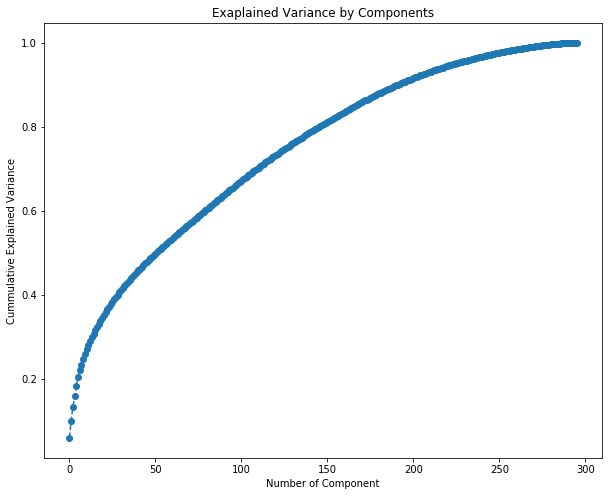

In [7]:
plt.figure(figsize=(10,8))
plt.plot(pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title("Exaplained Variance by Components")
plt.xlabel("Number of Component")
plt.ylabel("Cummulative Explained Variance")
plt.show()

**Note :** Rule of thumb is to preserve almost 80 % of the variance so we will decide to keep x Component

In [8]:
def reduce_component(df,n=250):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [9]:
pca_azdias = reduce_component(scaled_azdias)
pca_customers = reduce_component(scaled_customers)

0.9752386259216527
0.9716863419733648


In [12]:
# pca_azdias.to_pickle("pca_azdias.pkl")
# pca_customers.to_pickle("pca_customers.pkl")

In [13]:
# shape of reduced components
print(pca_azdias.shape)
print(pca_customers.shape)

(744305, 250)
(191652, 250)


## K - means clustering with PCA

**We need to determine the number of cluster** 

In order to do so, we run the algorithm with a different number of clusters. Then, we determine the Within Cluster Sum of Squares or WCSS for each solution. Based on the values of the WCSS and an approach known as the Elbow method, we make a decision about how many clusters we’d like to keep.

In our case, we test an algorithm with up to 20 clusters.

In [18]:
#taking too much time have to sample of data to compute this
# wcss=[]
# for i in range(1,21):
#     kmeans_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
#     kmeans_pca.fit(pca_azdias)
#     wcss.append(kmeans_pca.inertia_)

In [36]:
pca_azdias_sample=pca_azdias.sample(20000)

In [37]:
wcss=[]
score=[]
for i in range(1,21):
    #print(i)
    kmeans_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
    model=kmeans_pca.fit(pca_azdias_sample)
    wcss.append(model.inertia_)

Ploting the wcss againts the number of component

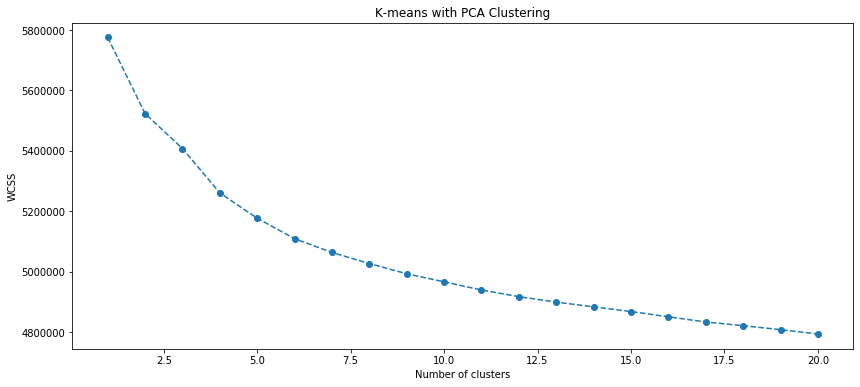

In [38]:
plt.figure(figsize=(14,6))
plt.plot(range(1,21),wcss,marker='o',linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

From this graph, we determine the **number of clusters** we’d like to keep. To that effect, we use the Elbow-method. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother

# Selecting K as

In [102]:
kmeans_K = KMeans(5)
model_k = kmeans_K.fit(pca_azdias)
prediction_azdias = model_k.predict(pca_azdias)
prediction_customers = model_k.predict(pca_customers)

In [108]:
# filename = 'model_k.sav'
# pickle.dump(model_k, open(filename, 'wb'))

In [103]:
# azdias_clustered = pd.DataFrame(prediction_azdias, columns = ['Cluster'])
# customers_clustered = pd.DataFrame(prediction_customers, columns = ['Cluster'])

In [104]:
(unique_pop, counts_pop) = np.unique(prediction_azdias, return_counts=True)
frequencies_pop = np.asarray((unique_pop, counts_pop)).T
pop=pd.DataFrame(frequencies_pop,columns=['Cluster','WholePop'])

(unique_cus, counts_cus) = np.unique(prediction_customers, return_counts=True)
frequencies_cus = np.asarray((unique_cus, counts_cus)).T
cus=pd.DataFrame(frequencies_cus,columns=['Cluster','Customers'])

df_info = pd.merge(pop,cus,on="Cluster")

df_info['population_percent'] = (df_info['WholePop']/df_stat['WholePop'].sum()*100).round(2)
df_info['customer_percent'] = (df_info['Customers']/df_stat['Customers'].sum()*100).round(2)
df_info

,Cluster,WholePop,Customers,population_percent,customer_percent
0,0,111016,42802,14.92,22.33
1,1,13823,166,1.86,0.09
2,2,167555,33988,22.51,17.73
3,3,234627,60278,31.52,31.45
4,4,217284,54418,29.19,28.39


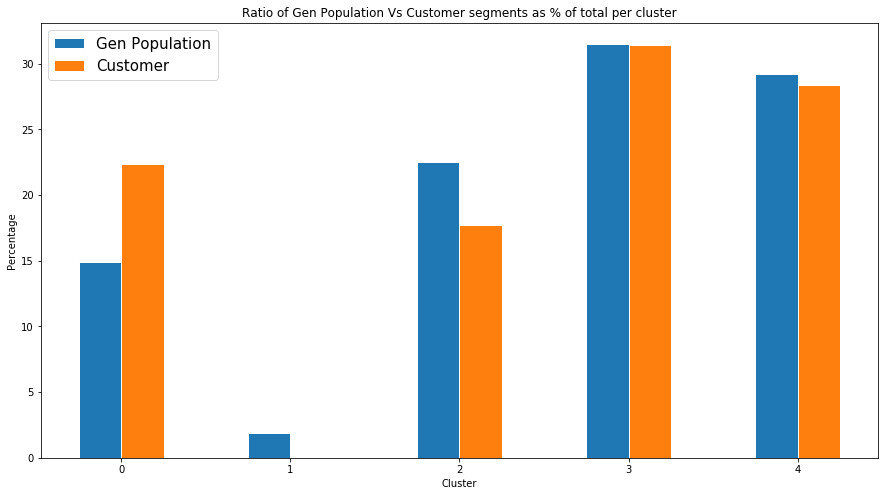

In [105]:
plt.figure(figsize=(15,8))
# set width of bar
barWidth = 0.25
# set height of bar
bars1 = df_info['population_percent']
bars2 = df_info['customer_percent']
label=df_info['Cluster']
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white')
plt.bar(r2, bars2, width=barWidth, edgecolor='white')

 
# Add xticks on the middle of the group bars
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], label)
 
# Create legend & Show graphic
plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

### we can see the order which we can find customers -> 
- cluster 3
- cluster 4
- cluster 0
- cluster 1